In [1]:
!pip install pims av
!python --version

     |████████████████████████████████| 92kB 6.7MB/s 
     |████████████████████████████████| 37.2MB 83kB/s 
  Created wheel for pims: filename=PIMS-0.5-cp37-none-any.whl size=84328 sha256=cd46e234c674c825f465bff18a56b8fe991c1b095c870759bf443817a0fd926d
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims
Python 3.7.10


In [2]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3366912/45929032 bytes (7.3%)7421952/45929032 bytes (16.2%)11509760/45929032 bytes (25.1%)14876672/45929032 bytes (32.4%)17448960/45929032 bytes (38.0%)21282816/45929032 bytes (46.3%)25165824/45929032 bytes (54.8%)29122560/45929032 bytes (63.4%)33103872/45929032 bytes (72.1%)36798464/45929032 bytes (80.1%)40681472/45929032 bytes (88.6%)44883968/45929032 bytes (97.7%)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# CONSTANTS
# network input resolution
W = 320
H = 160

# annotations' resolution
annot_W = 480
annot_H = 320

In [5]:
# DATA FUNCTIONS
from os import listdir

# get polylines from file
def extract_polylines(filename):
  tree = ET.parse(filename)
  polylines = []
  for polyline in tree.iter(tag='polyline'):
    frame = polyline.get("frame")
    points = polyline.get("points").split(";")
    for i in range(len(points)):
      points[i] = points[i].split(",")
      for j in range(len(points[i])):
        points[i][j] = float(points[i][j])
    data = (int(frame), points)
    polylines.append(data)

  return sorted(polylines)

# get polylines from each frame
def extract_frame_lines(polylines):
  n_frames = polylines[-1][0]
  frames = []

  for i in range(n_frames+1):
    frame = []
    for polyline in polylines:
      if polyline[0] == i:
        frame.append(polyline[1])
    frames.append(sorted(frame))
    
  return frames

# convert annotations to new resolution
def convert_annotations(old_res, new_res, annotations):
  W, H = old_res
  new_W, new_H = new_res
  new_annotations = []
  for polylines in annotations:
    new_polylines = []
    for polyline in polylines:
      new_polyline = []
      for point in polyline:
        x, y = point
        new_x = (x*new_W) / W
        new_y = (y*new_H) / H
        new_polyline.append([new_x,new_y])
      new_polylines.append(new_polyline)
    new_annotations.append(new_polylines)
  return np.array(new_annotations)

# get training data from path
def get_data(video_path, annotations_path):
  # get video frames
  frames = pims.Video(video_path, format="mp4")
  
  # get road edges data
  annotations = extract_polylines(annotations_path)
  annotations = extract_frame_lines(annotations)
  annotations = convert_annotations((annot_W,annot_H), (W,H), annotations)

  return frames, annotations

# make pims video into actual numpy frames
def conv_frames(frames):
  imgs = []
  print("Getting frames into proper arrays")
  for frame in frames:
    imgs.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (W,H)))
  print("Frames converted to numpy arrays")
  return np.array(imgs)

base_dir = "/content/drive/MyDrive/OpenCRD_dataset/"
video_files = []
annot_files = []
for f in listdir(base_dir):
  if f.endswith(".mp4"):
    video_files.append(f)
  elif f.endswith(".xml"):
    annot_files.append(f)
video_files, annot_files = sorted(video_files), sorted(annot_files)

video_files = video_files[:3] # TODO: this is a temp hack, need to get all videos' annotations
print(video_files)
print(annot_files)

assert len(video_files) == len(annot_files), "Number of video files != number of annotation files"

['city_1.mp4', 'city_2.mp4', 'city_3.mp4']
['city_1_annotations.xml', 'city_2_annotations.xml', 'city_3_annotations.xml']


In [6]:
# PYTOCH MODEL
# model for road edge detection
class REDetector(nn.Module):
  def __init__(self):
    super(REDetector, self).__init__()

    # output polylines attributes
    self.n_coords = 2  # 2 coordinates: x,y
    self.n_points = 4  # number of points of each polyline
    self.max_n_lines = 6 # max number of polylines per frame

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2d_bn1 = nn.BatchNorm2d(16)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv2d_bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv2d_bn3 = nn.BatchNorm2d(64)

    # Fully Connected Layers
    self.fc1 = nn.Linear(64*16*36, 120) # for 320x160 image 64 channels
    self.bn1 = nn.BatchNorm1d(num_features=120)
    self.fc2 = nn.Linear(120, 84)
    self.bn2 = nn.BatchNorm1d(num_features=84)
    self.fc3 = nn.Linear(84, self.n_coords*self.n_points*self.max_n_lines)

  def forward(self, x):
    x = self.pool(F.relu(self.conv2d_bn1(self.conv1(x))))
    x = self.pool(F.relu(self.conv2d_bn2(self.conv2(x))))
    x = self.pool(F.relu(self.conv2d_bn3(self.conv3(x))))
    #print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.fc3(x)

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [7]:
# ANNOTATIONS TRANSFORMATIONS

# TODO: this algorithm has bad complexity (O(n^3)), refactor if possible
# convert polylines per frame to net output vector (flattens the array)
def serialize_polylines(polylines, n_coords, n_points, max_n_lines):
  # check if we have more than n_points
  # TODO: instead of removing the whole line, just get polyline[:n_points]
  for polyline in polylines:
    if len(polyline) != n_points:
      polylines.remove(polyline)
  assert len(polylines) <= max_n_lines, "More than max number of lines found"

  # fill the gaps with negative values (-1 == NULL => out of bounds)
  if len(polylines) < max_n_lines:
    for i in range(max_n_lines - len(polylines)):
      new_polyline = []
      for j in range(n_points):
        point = []
        for k in range(n_coords):
          point.append(-1.0)
        new_polyline.append(point)
      polylines.append(new_polyline)
      
  # flatten
  ret = []
  for i in range(max_n_lines):
    for j in range(n_points):
      for k in range(n_coords):
        ret.append(polylines[i][j][k])

  return np.array(ret)

# TODO: this needs more work depending on the net output, since it is tested only on annotations
# convert network output vector to polylines per frame
def deserialize_polylines(net_output, n_coords, n_points, max_n_lines):
  polylines = []
  point = []
  line = []
  for i in range(len(net_output)):
    point.append(net_output[i])
    if len(point) == 2:
      line.append(point)
      point = []
    if len(line) == 4:
      polylines.append(line)
      line = []

  # remove (-1, -1)/out-of-bounds points from lines
  for polyline in polylines:
    while [-1., -1.] in polyline:
      polyline.remove([-1., -1.]) # TODO: remove all negative numbers, not just (-1., -1.) pairs

  # remove empty lists
  while [] in polylines:
    polylines.remove([])

  return np.array(polylines)

In [ ]:
# test the above functions (this will be later used on the training loop for Y_train)
n_coords = 2  # 2 coordinates: x,y
n_points = 4  # number of points of each polyline
max_n_lines = 6 # max number of polylines per frame

frames, annotations = get_data(base_dir+video_files[1], base_dir+annot_files[1])

idx = 0
for polylines in annotations:
  ret = serialize_polylines(polylines, n_coords, n_points, max_n_lines)
  print("++++++++++")
  print("Frame", idx)
  print(ret)
  print("==========")
  new_polylines = deserialize_polylines(ret, n_coords, n_points, max_n_lines)
  print(new_polylines)
  idx += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Streaming output truncated to the last 5000 lines.
  [2.11333333e+01 1.11100000e+02]
  [5.48666667e+01 1.06150000e+02]]

 [[1.93333333e+02 1.05750000e+02]
  [2.19533333e+02 1.15050000e+02]
  [2.73000000e+02 1.34500000e+02]
  [3.19000000e+02 1.51500000e+02]]]
++++++++++
Frame 701
[ 2.66666667e-01  1.14900000e+02  1.19333333e+01  1.12750000e+02
  2.06733333e+01  1.11185000e+02  5.32600000e+01  1.06275000e+02
  1.93746667e+02  1.05905000e+02  2.19946667e+02  1.15145000e+02
  2.73126667e+02  1.34470000e+02  3.19000000e+02  1.51375000e+02
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.0

[~] Cleared cuda cache


[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_2.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_2_annotations.xml


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Getting frames into proper arrays
Frames converted to numpy arrays
[~] Loading from files: /content/drive/MyDrive/OpenCRD_dataset/city_3.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_3_annotations.xml
Getting frames into proper arrays
Frames converted to numpy arrays

(1819, 160, 320, 3)
(1820,)
[+] Training mode ...
[+] Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128, 1, 48])) that is different to the input size (torch.Size([128, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[+] Epoch 11



[+] Epoch 12



[+] Epoch 13



[+] Epoch 14



[+] Epoch 15



[+] Epoch 16



[+] Epoch 17



[+] Epoch 18



[+] Epoch 19



[+] Epoch 20



[+] Epoch 21



[+] Epoch 22



[+] Epoch 23



[+] Epoch 24



[+] Epoch 25



[+] Epoch 26



[+] Epoch 27



[+] Epoch 28



[+] Epoch 29



[+] Epoch 30



[+] Epoch 31



[+] Epoch 32



[+] Epoch 33



[+] Epoch 34



[+] Epoch 35



[+] Epoch 36



[+] Epoch 37



[+] Epoch 38



[+] Epoch 39



[+] Epoch 40



[+] Epoch 41



[+] Epoch 42



[+] Epoch 43



[+] Epoch 44



[+] Epoch 45



[+] Epoch 46



[+] Epoch 47



[+] Epoch 48



[+] Epoch 49



[+] Epoch 50



[+] Epoch 51



[+] Epoch 52



[+] Epoch 53



[+] Epoch 54



[+] Epoch 55



[+] Epoch 56



[+] Epoch 57



[+] Epoch 58



[+] Epoch 59



[+] Epoch 60



[+] Epoch 61



[+] Epoch 62



[+] Epoch 63



[+] Epoch 64



[+] Epoch 65



[+] Epoch 66



[+] Epoch 67



[+] Epoch 68



[+] Epoch 69



[+] Epoch 70



[+] Epoch 71



[+] Epoch 72



[+] Epoch 73



[+] Epoch 74



[+] Epoch 75



[+] Epoch 76



[+] Epoch 77



[+] Epoch 78



[+] Epoch 79



[+] Epoch 80



[+] Epoch 81



[+] Epoch 82



[+] Epoch 83



[+] Epoch 84



[+] Epoch 85



[+] Epoch 86



[+] Epoch 87



[+] Epoch 88



[+] Epoch 89



[+] Epoch 90



[+] Epoch 91



[+] Epoch 92



[+] Epoch 93



[+] Epoch 94



[+] Epoch 95



[+] Epoch 96



[+] Epoch 97



[+] Epoch 98



[+] Epoch 99



tensor([[ 39.3962, 146.2624, 129.0067,  ..., -14.2913,  -3.5920,  12.3888],
        [ 40.5291, 148.1257, 129.2333,  ..., -14.2607,  -3.7987,  12.7248],
        [ 39.7667, 147.2650, 128.3135,  ..., -14.2565,  -3.7504,  12.6151],
        ...,
        [ 30.0652, 140.7231, 119.4316,  ...,  -2.7179,   1.2947,  -4.5657],
        [ 30.0824, 140.5721, 119.4349,  ...,  -2.7613,   1.2836,  -4.5784],
        [ 30.1043, 140.3757, 119.2471,  ...,  -2.7524,   1.2814,  -4.5725]],
       device='cuda:0', grad_fn=<AddmmBackward>)
[+] Trained model on all data files


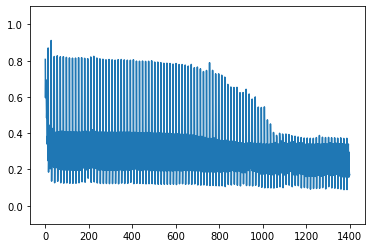

In [15]:
# TRAINING PROCESS
# TODO: model does not learn!!!
def train(frames, annotations, model):
  loss_function = nn.MSELoss()
  optim = torch.optim.Adam(model.parameters(), lr=0.1)  # TODO: try new learning rates (maybe increase the rate)

  losses, accuracies = [], []
  #epochs = 11
  epochs = 100
  BS = 128

  for epoch in range(epochs):
    print("[+] Epoch", epoch)
    t = trange(0, len(frames)-BS, BS)
    for i in t: 
      # get data into network
      X_train = []
      Y_train = []

      """
      rng = np.random.default_rng()
      samp = rng.choice(len(frames), size=BS, replace=False)
      for j in samp:
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append([flat_annot])
      """
      
      # NOTE: this might work better here, but it is not compatible with multitask learning
      # without random sample
      for j in range(i, i+BS):
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0)
        X_train.append(frame)
        flat_annot = serialize_polylines(annotations[j], model.n_coords, model.n_points, model.max_n_lines)
        Y_train.append([flat_annot])
      X = torch.tensor(np.array(X_train)).float().to(device)
      Y = torch.tensor(np.array(Y_train)).float().to(device)

      # forward and back feed
      optim.zero_grad()
      out = model(X)
      #accuracy = (out == Y).float().mean()  # TODO: this might be wrong
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print stats
      loss = loss.item()
      #accuracy = accuracy.item()
      losses.append(loss/10000) # /10000 so that we can see it in the graph
      #accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f out %.2f" % (loss, accuracy, out.mean().item()))
      t.set_description("loss %.2f out %.2f" % (loss, out.mean().item()))

  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(losses)
  #plot(accuracies)
  print(out)

  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")

model = REDetector().to(device).train()

for i in trange(1, len(video_files)):
  print("[~] Loading from files: %s , %s" % (base_dir+video_files[i], base_dir+annot_files[i]))
  frames, annotations = get_data(base_dir+video_files[i], base_dir+annot_files[i])
  frames = conv_frames(frames)
  #if i == 0:
  if i == 1:
    all_frames = frames
    all_annotations = annotations
  else:
    all_frames = np.concatenate((all_frames, frames), axis=0)
    all_annotations = np.concatenate((all_annotations, annotations), axis=0)

frames, labels = [], [] # free up memory
print(all_frames.shape)
print(all_annotations.shape)
print("[+] Training mode ...")
model = train(all_frames, all_annotations[:-1], model)
print("[+] Trained model on all data files")

In [ ]:
# TODO: evaluate model
def evalutate(mode, X_test, Y_test):
  pass

In [16]:
# save model for later retraining
#model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector.pth"
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom.pth"
torch.save(model.state_dict(), model_path)
print("Model saved to path", model_path)

Model saved to path /content/drive/MyDrive/OpenCRD_dataset/models/re_detector_nonrandom.pth
